This notebook parses top 100 MTA station names, pull station names from MTA turnstile data into pandas dataframe

- join the top 100 MTA stations to zip code data , based on station
- join the zip code data to census data, based on the zip code.
- visualize to identify the correlation of some features in joined dataset
- give recommendation for busy station based on rank of total traffic, income over 200k and public transportation

In [1]:
# common modules
import pandas as pd

# plot modules
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
df_census = pd.read_pickle('census_nyc.pkl')
df_census.head()

,zip_code,total_households,percent_100_149k,percent_150_199k,percent_200k_over,percent_public_trans
2,10001,12347.0,15.7,6.2,22.4,46.1
3,10002,33461.0,9.2,4.0,6.4,53.8
4,10003,26699.0,14.4,10.6,26.8,53.1
5,10004,1587.0,25.4,14.0,33.0,59.3
6,10005,4239.0,22.8,16.0,37.5,64.0


In [3]:
df_zipcode = pd.read_csv('zipcodes.csv', names = ["STATION", "zip_code"])
df_zipcode.head()

,STATION,zip_code
0,34 ST-PENN STA,10001
1,FULTON ST,11217
2,GRD CNTRL-42 ST,10017
3,TIMES SQ-42 ST,10018
4,34 ST-HERALD SQ,10001


In [4]:
df_top = pd.read_pickle('top_100_stations.pkl')
df_top.head()

,STATION,DAILY_TRAFFIC
61,34 ST-PENN STA,81031625.0
233,GRD CNTRL-42 ST,74387325.0
59,34 ST-HERALD SQ,58803013.0
353,TIMES SQ-42 ST,49815477.0
46,23 ST,49153788.0


In [5]:
#merge two df by STATION
df = df_top.merge(df_zipcode, how='left', on='STATION')
df.head()

,STATION,DAILY_TRAFFIC,zip_code
0,34 ST-PENN STA,81031625.0,10001.0
1,GRD CNTRL-42 ST,74387325.0,10017.0
2,34 ST-HERALD SQ,58803013.0,10001.0
3,TIMES SQ-42 ST,49815477.0,10018.0
4,23 ST,49153788.0,10011.0


In [6]:
# save to pickle file
df.to_pickle('top_100_stations_zipcode.pkl')
# read from pickle file
df = pd.read_pickle('top_100_stations_zipcode.pkl')
df.head()

,STATION,DAILY_TRAFFIC,zip_code
0,34 ST-PENN STA,81031625.0,10001.0
1,GRD CNTRL-42 ST,74387325.0,10017.0
2,34 ST-HERALD SQ,58803013.0,10001.0
3,TIMES SQ-42 ST,49815477.0,10018.0
4,23 ST,49153788.0,10011.0


In [7]:
df = df.merge(df_census, how='left', on='zip_code') 
df = df.dropna() 
df.head()

,STATION,DAILY_TRAFFIC,zip_code,total_households,percent_100_149k,percent_150_199k,percent_200k_over,percent_public_trans
0,34 ST-PENN STA,81031625.0,10001.0,12347.0,15.7,6.2,22.4,46.1
1,GRD CNTRL-42 ST,74387325.0,10017.0,10076.0,17.1,15.2,25.1,37.0
2,34 ST-HERALD SQ,58803013.0,10001.0,12347.0,15.7,6.2,22.4,46.1
3,TIMES SQ-42 ST,49815477.0,10018.0,4993.0,19.0,11.2,25.0,44.4
4,23 ST,49153788.0,10011.0,28753.0,16.6,11.7,29.6,55.4


In [8]:
df.columns

Index(['STATION', 'DAILY_TRAFFIC', 'zip_code', 'total_households',
       'percent_100_149k', 'percent_150_199k', 'percent_200k_over',
       'percent_public_trans'],
      dtype='object')

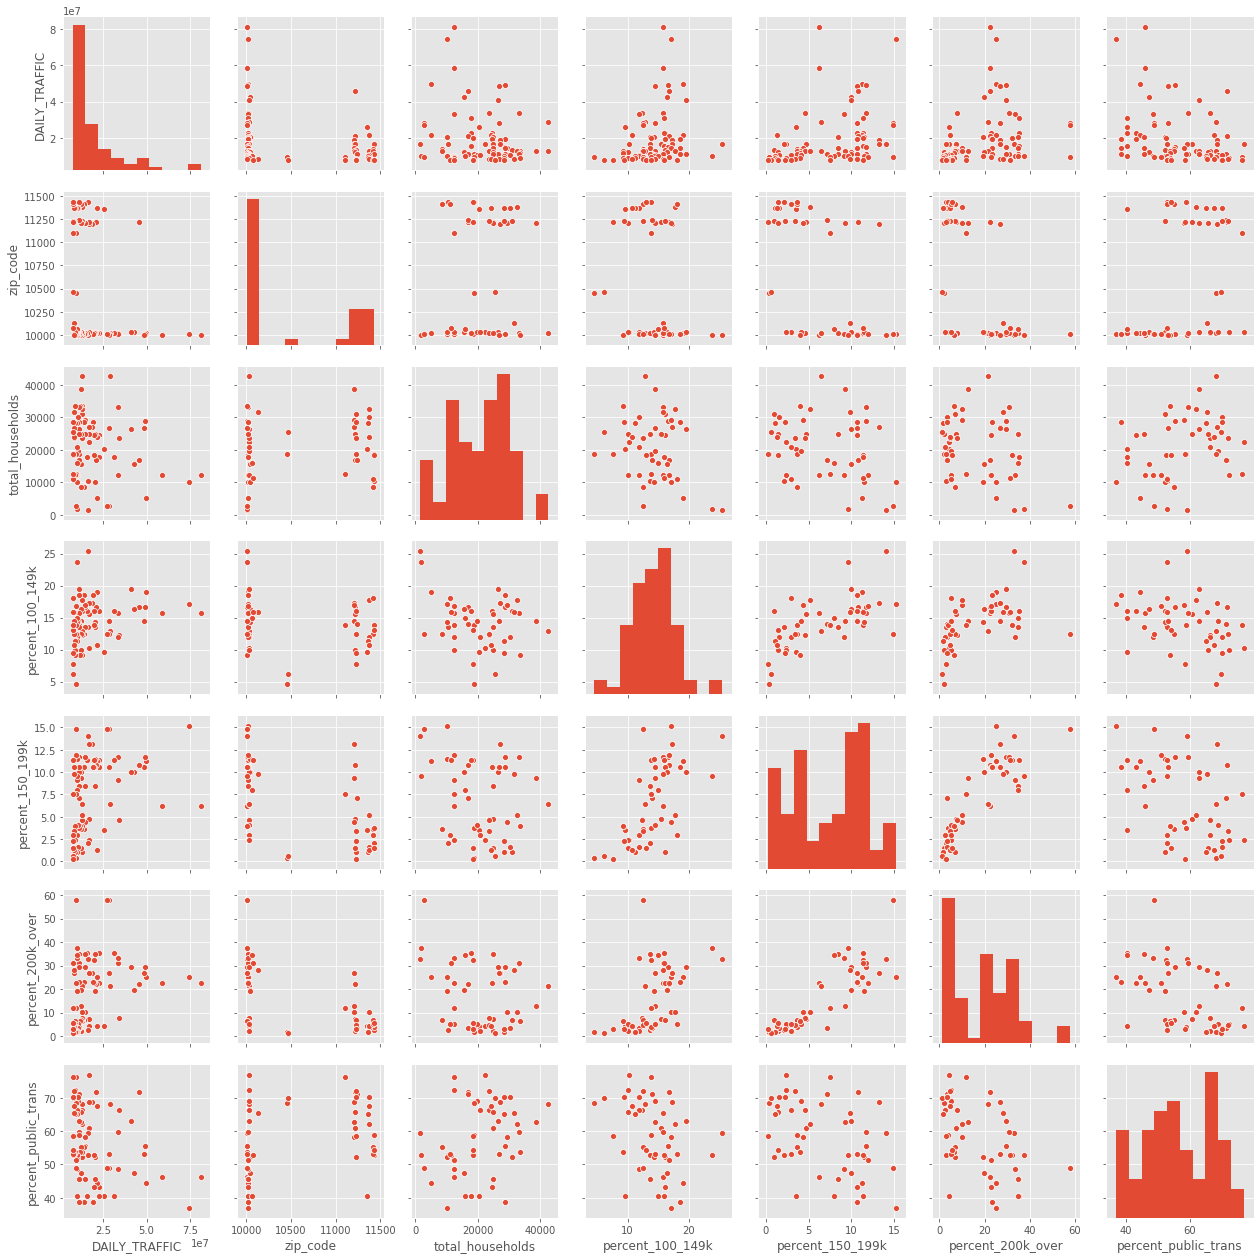

In [9]:
import seaborn as sns
sns.pairplot(df);

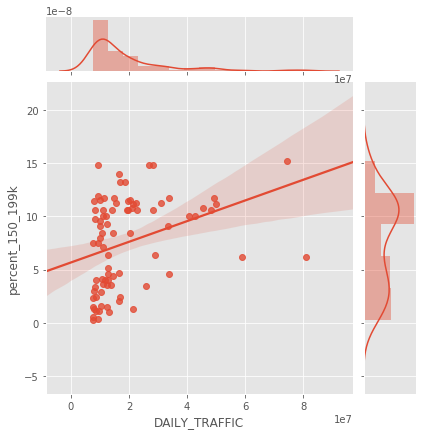

In [10]:
sns.jointplot('DAILY_TRAFFIC', 'percent_150_199k', kind="regplot", data=df)

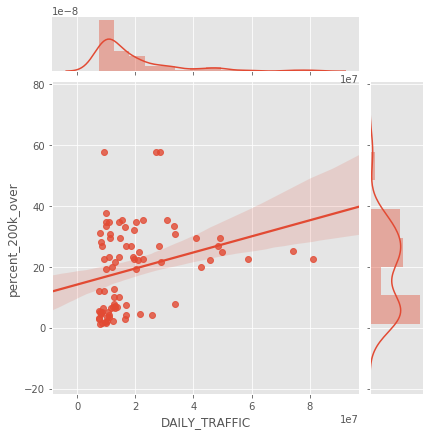

In [11]:
sns.jointplot('DAILY_TRAFFIC', 'percent_200k_over', kind="regplot", data=df) 

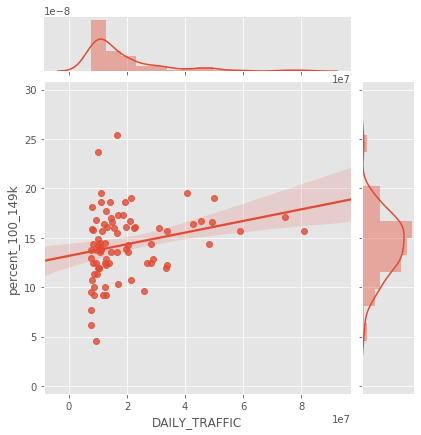

In [12]:
sns.jointplot('DAILY_TRAFFIC',  'percent_100_149k', kind="regplot", data=df)  

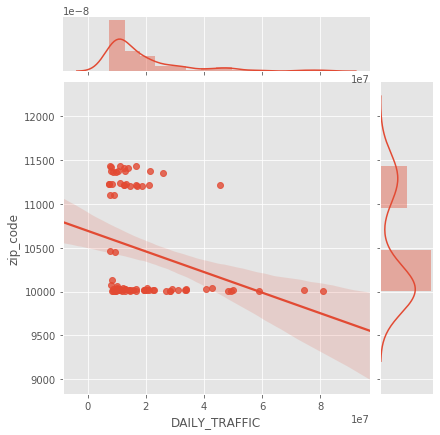

In [13]:
sns.jointplot('DAILY_TRAFFIC',  'zip_code', kind="regplot", data=df) 

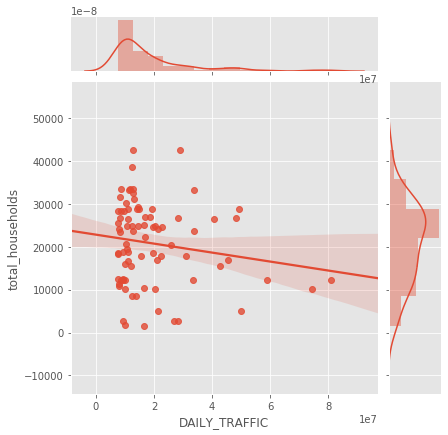

In [14]:
sns.jointplot('DAILY_TRAFFIC',  'total_households', kind="regplot", data=df) 

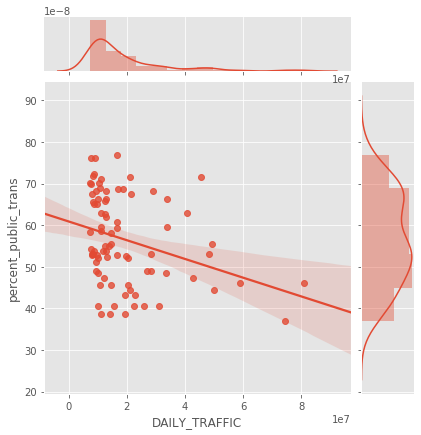

In [15]:
sns.jointplot('DAILY_TRAFFIC',  'percent_public_trans', kind="regplot", data=df) 

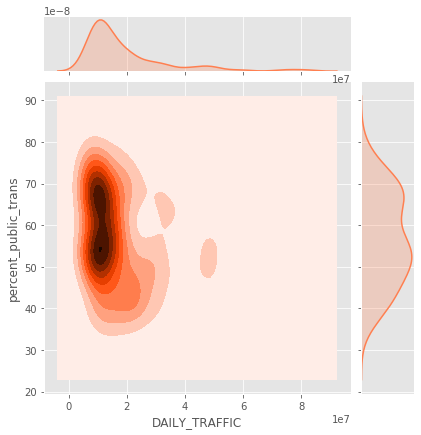

In [16]:
sns.jointplot('DAILY_TRAFFIC',  'percent_public_trans', kind="kde", data=df, color='coral') 

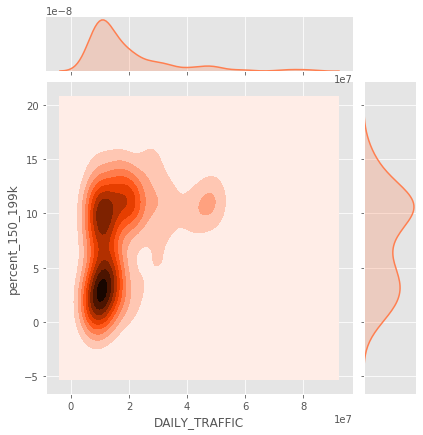

In [17]:
sns.jointplot('DAILY_TRAFFIC', 'percent_150_199k', kind="kde", data=df, color='coral')


#### Create ranking column for each column 'DAILY_TRAFFIC', 'percent_200k_over', 'percent_public_trans'

In [18]:
#[i[0] for i in sorted(enumerate(df.percent_public_trans), key=lambda x:x[1])]
#[sorted(l).index(x) for x in l]

df['TRAFFIC_RANK'] = [sorted(df.DAILY_TRAFFIC).index(x) for x in df.DAILY_TRAFFIC]
df['PUBLIC_TRANS_RANK'] = [sorted(df.percent_public_trans).index(x) for x in df.percent_public_trans]
df['200K_RANK'] = [sorted(df.percent_200k_over).index(x) for x in df.percent_200k_over]


df.columns

Index(['STATION', 'DAILY_TRAFFIC', 'zip_code', 'total_households',
       'percent_100_149k', 'percent_150_199k', 'percent_200k_over',
       'percent_public_trans', 'TRAFFIC_RANK', 'PUBLIC_TRANS_RANK',
       '200K_RANK'],
      dtype='object')

#### Evaluate the recommendation base on ridership, public transportation and income over 200k

In [19]:
traffic_factor = 0.6
commute_factor = 0.2
income_factor = 0.2

df['SCORE'] =  traffic_factor*df['TRAFFIC_RANK'] + commute_factor*df['PUBLIC_TRANS_RANK'] + \
income_factor*df['200K_RANK']

df = df.sort_values('SCORE', ascending=False)

#### Top 10 stations with highest score

In [20]:
top_10_recommended = df[['STATION','SCORE','zip_code', 'TRAFFIC_RANK', 'PUBLIC_TRANS_RANK','200K_RANK'] ][:10]
top_10_recommended 

,STATION,SCORE,zip_code,TRAFFIC_RANK,PUBLIC_TRANS_RANK,200K_RANK
6,FULTON ST,68.2,11217.0,75,75,41
4,23 ST,67.2,10011.0,77,43,62
8,86 ST,66.6,10028.0,73,54,60
10,59 ST COLUMBUS,65.2,10023.0,71,49,64
5,14 ST-UNION SQ,63.2,10003.0,76,34,54
14,96 ST,61.6,10025.0,68,65,39
9,125 ST,61.0,10027.0,72,61,28
0,34 ST-PENN STA,60.4,10001.0,81,16,43
15,PATH NEW WTC,60.4,10007.0,67,22,79
11,CANAL ST,59.8,10013.0,70,20,69


#### Save top 10 stations to csv

In [21]:
top_10_recommended.to_csv('top_10_recommended.csv')

In [22]:
df_station_location = pd.read_csv('station_location.csv', names = ["STATION", "LOCATION"])
df_station_location.head()

,STATION,LOCATION
0,34 ST-PENN STA,"({'lat': 40.751056, 'lng': -73.9903102}, '34 S..."
1,GRD CNTRL-42 ST,"({'lat': 40.7522378, 'lng': -73.97717879999999..."
2,34 ST-HERALD SQ,"({'lat': 40.7496439, 'lng': -73.9876706}, '34 ..."
3,TIMES SQ-42 ST,"({'lat': 40.7552574, 'lng': -73.986933}, 'Time..."
4,23 ST,"({'lat': 40.7461165, 'lng': -73.99815749999999..."


In [66]:
def extract_location(loc):
    lat = loc.split(" ")[1][:-1]
    lat = float(lat)
    lon = loc.split(" ")[3][:-2]
    lon = float(lon)
    return (lat, lon)

df_station_location['LAT/LON'] = df_station_location['LOCATION'].apply(lambda x : extract_location(x))

df_station_location.head()

,STATION,LOCATION,LAT/LON
0,34 ST-PENN STA,"({'lat': 40.751056, 'lng': -73.9903102}, '34 S...","(40.751056, -73.9903102)"
1,GRD CNTRL-42 ST,"({'lat': 40.7522378, 'lng': -73.97717879999999...","(40.7522378, -73.97717879999999)"
2,34 ST-HERALD SQ,"({'lat': 40.7496439, 'lng': -73.9876706}, '34 ...","(40.7496439, -73.9876706)"
3,TIMES SQ-42 ST,"({'lat': 40.7552574, 'lng': -73.986933}, 'Time...","(40.7552574, -73.986933)"
4,23 ST,"({'lat': 40.7461165, 'lng': -73.99815749999999...","(40.7461165, -73.99815749999999)"


In [72]:
dic = {}
for i in top_10_recommended['STATION']:
    loc = df_station_location[df_station_location['STATION'] == i]['LAT/LON']
    print(loc)
    dic[i] = loc

6    (40.7098694, -74.00702540000002)
Name: LAT/LON, dtype: object
4    (40.7461165, -73.99815749999999)
Name: LAT/LON, dtype: object
8    (40.7780602, -73.9521931)
Name: LAT/LON, dtype: object
10    (40.7684839, -73.981807)
Name: LAT/LON, dtype: object
5    (40.7348024, -73.990753)
Name: LAT/LON, dtype: object
14    (40.7932251, -73.96837359999999)
Name: LAT/LON, dtype: object
9    (40.8107718, -73.95261459999999)
Name: LAT/LON, dtype: object
0    (40.751056, -73.9903102)
Name: LAT/LON, dtype: object
15    (40.7126452, -74.00989799999999)
Name: LAT/LON, dtype: object
11    (40.719393, -74.0018987)
Name: LAT/LON, dtype: object
